In [1]:
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import *

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from binary_cmatrix import plot_binary_cm
from binary_cmatrix import binary_cm
from senspec import cm2senspec

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from pandas import DataFrame
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
data = pd.read_csv("grade_biobank.csv")
images = "/work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images"

#### Check that metadata matches directory

In [3]:
i = os.listdir(images)
Files = pd.DataFrame(i, columns=['Filename'])
data = data.merge(Files, how = "inner", on = "Filename")

In [4]:
data

,Deck/Slide,Folder,Filename,Grade
0,1.01,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150923171233.2.9...,3
1,1.02,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150923173922.2.9...,2
2,1.03,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150924134659.2.9...,0
3,1.04,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150927084428.1.9...,0
4,1.05,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150928094534.2.9...,2
...,...,...,...,...
541,HD3.78,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181106114754.1.9...,2
542,HD3.79,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181120094219.1.9...,2
543,HD3.80,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181128133806.1.9...,2
544,HD3.81,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181210165242.1.9...,4


In [20]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data, test_size = 0.2, random_state=42)
val_df.loc[:,'is_valid']=True
train_df.loc[:,'is_valid']=False
train_df.to_csv("KL_Grade_Training_Data.csv")
val_df.to_csv("KL_Grade_Validation_Data.csv")

In [21]:
train_df

,Deck/Slide,Folder,Filename,Grade,is_valid
93,3.033,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20180530091657.1.6...,1,False
335,HD1.32,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151201140032.1.9...,3,False
412,HD2.29,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20180724105815.1.6...,4,False
473,HD3.07,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20181122181900.1.9...,4,False
237,3.035,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20181120164609.1.6...,2,False
...,...,...,...,...,...
71,1.71,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20151018084109.2.6...,2,False
106,2.004,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.212174.20190417184957.1.9...,1,False
270,3.066,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20160808173050.1.6...,2,False
435,HD2.51,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20170113190930.1.9...,3,False


In [22]:
val_df

,Deck/Slide,Folder,Filename,Grade,is_valid
316,HD1.13,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151011131336.2.9...,4,True
77,1.77,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151015113535.2.9...,3,True
360,HD1.58,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20160112135812.1.6...,4,True
90,1.89,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20170924110922.1.9...,2,True
495,HD3.30,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212038.20170921114548.1.9...,2,True
...,...,...,...,...,...
357,HD1.55,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151205091023.1.6...,3,True
39,1.4,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006133134.2.9...,1,True
54,1.54,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006163631.2.9...,3,True
155,2.052,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.212038.20171122120316.1.9...,2,True


In [12]:
train_df = pd.read_csv("KL_Grade_Training_Data.csv")
val_df = pd.read_csv("KL_Grade_Validation_Data.csv")

In [10]:
image_df = pd.concat([train_df, val_df])

In [5]:
tfms = get_transforms()
size = 224
bs = 62

data = (ImageList.from_df(image_df, path=images, cols="Filename")
              .split_from_df(col="is_valid")
              .label_from_df(cols="Grade")
              .transform(tfms, size=size).databunch(bs=bs, num_workers=4).normalize(imagenet_stats))

In [25]:
data

ImageDataBunch;

Train: LabelList (436 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,3,4,4,2
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Valid: LabelList (110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,3,4,2,2
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Test: None

In [26]:
# need to figure out how to calculate this

class MultiLabelFbeta(Callback):
    # Computes the fbeta score for multilabel classification
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    _order = -20 
    def __init__(self, beta=2, eps=1e-15, thresh=0.3, sigmoid=True, average="micro"):
        self.eps,self.thresh,self.sigmoid,self.average,self.beta = eps,thresh,sigmoid,average,beta

    def on_epoch_begin(self, **kwargs):
        self.tp,self.total_pred,self.total_targ = 0,0,0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        pred, targ = ((last_output.sigmoid() if self.sigmoid else last_output) > self.thresh).byte(), last_target.byte()
        m = pred*targ
        self.tp += m.sum(0).float()
        self.total_pred += pred.sum(0).float()
        self.total_targ += targ.sum(0).float()
    
    def fbeta_score(self, precision, recall):
        beta2 = self.beta**2
        return (1 + beta2)*(precision*recall)/((beta2*precision + recall) + self.eps)

    def on_epoch_end(self, last_metrics, **kwargs):
        self.total_pred += self.eps
        self.total_targ += self.eps
        if self.average == "micro":
            precision, recall = self.tp.sum() / self.total_pred.sum(), self.tp.sum() / self.total_targ.sum()
            res = self.fbeta_score(precision, recall)
        elif self.average == "macro":
            res = self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ)).mean()
        elif self.average == "weighted":
            scores = self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ))
            res = (scores*self.total_targ).sum() / self.total_targ.sum()
        elif self.average == "none":
            res = listify(self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ)))
        else:
            raise Exception("Choose one of the average types: [micro, macro, weighted, none]")
        
        return add_metrics(last_metrics, res)

# Initial - No Changes Made

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model_dir="./KL_Models"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.00E-02


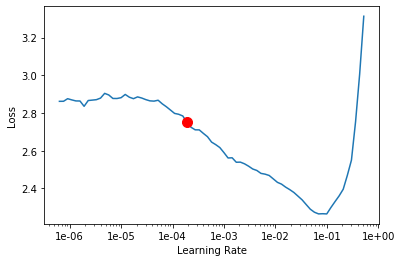

In [32]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(24, slice(2e-4, 2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.835111,1.965150,0.790909,00:06
1,2.643560,1.939542,0.745455,00:06
2,2.425522,1.961841,0.700000,00:06
3,2.296415,1.830258,0.572727,00:06
4,2.194525,2.269853,0.645455,00:06
5,2.129623,1.988872,0.581818,00:06
6,2.022593,1.980026,0.645455,00:06
7,1.947308,1.768049,0.590909,00:06
8,1.850928,1.741880,0.572727,00:07
9,1.758601,1.727392,0.572727,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-07


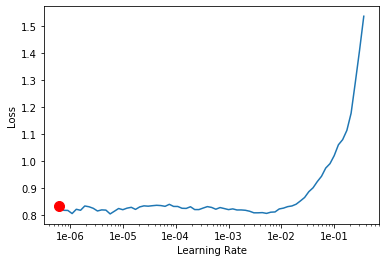

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.save('KL_1')

In [36]:
learn.fit_one_cycle(20, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.840927,1.200213,0.490909,00:07
1,0.826976,1.199331,0.481818,00:06
2,0.831432,1.183334,0.481818,00:07
3,0.818921,1.203171,0.490909,00:06
4,0.817230,1.208660,0.490909,00:06
5,0.841121,1.197816,0.490909,00:07
6,0.839000,1.192513,0.500000,00:06
7,0.849235,1.193333,0.490909,00:06
8,0.850583,1.196143,0.490909,00:06
9,0.847375,1.209528,0.481818,00:06


In [37]:
learn.save('KL_2')

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(20, slice(2e-6//400, 1e-5//100))

epoch,train_loss,valid_loss,error_rate,time
0,0.802031,1.195891,0.500000,00:07
1,0.797808,1.205722,0.490909,00:07
2,0.816777,1.185429,0.481818,00:07
3,0.809137,1.195683,0.490909,00:07
4,0.814662,1.196373,0.490909,00:07
5,0.812390,1.184374,0.490909,00:07
6,0.797212,1.178254,0.472727,00:07
7,0.797664,1.185882,0.472727,00:07
8,0.811319,1.187799,0.472727,00:07
9,0.810010,1.194409,0.490909,00:07


In [40]:
learn.save('KL_3')

In [7]:
learn.load('KL_3')

Learner(data=ImageDataBunch;

Train: LabelList (436 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,3,4,4,2
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Valid: LabelList (110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,3,4,2,2
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNor

In [8]:
preds, y = learn.get_preds()

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

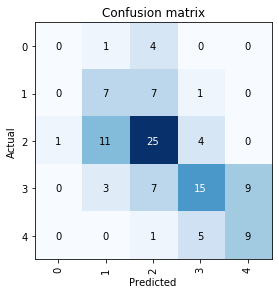

In [47]:
interp.plot_confusion_matrix()

In [61]:
k1 = 7 / (8 + 7)
k2 = 25 / (1+11+4+25)
k3 = 15 / (3+7+9+15)
k4 = 9 / (5+1+9)

In [62]:
print(k1, k2, k3, k4)

0.4666666666666667 0.6097560975609756 0.4411764705882353 0.6


# Interpretation
Model seems to have a really hard time distinguishing between moderate / severe OA and no OA at all. While there is no overlap between a classification of grade 3 and 4 and a grade of 0 and 1, there is significant overlap within adjacent categories. Model is likely to select nearest neigbhors to the correct KL grade.

One important thing to consider is clinical relevancy and sources of bias; ie how likely is someone to vacilate between a grade 3 and 4 or a grade 2 or 3, versus a grade 0 and a grade 4? Should I try scaling down to mild, moderate and severe? This may account for any subjective bias in grading, performance classifying many classes with a relatively small training dataset, while still giving us a clincially relevant phenotype to work with. 

One option is to make sure that the training data is balanced sufficiently to reduce any bias in training. 

Another is to oversample hard to classify grades only to increase the penalty associated with their loss, and similarly increase the penalty weight associated with missing hard to classify grades (on a balanced and imbalanced training dataset). 



# surgery vs no surgery

In [8]:
image_df

,Unnamed: 0,Deck/Slide,Folder,Filename,Grade,is_valid
0,93,3.033,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20180530091657.1.6...,1,False
1,335,HD1.32,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151201140032.1.9...,3,False
2,412,HD2.29,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20180724105815.1.6...,4,False
3,473,HD3.07,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20181122181900.1.9...,4,False
4,237,3.035,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20181120164609.1.6...,2,False
...,...,...,...,...,...,...
105,357,HD1.55,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151205091023.1.6...,3,True
106,39,1.4,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006133134.2.9...,1,True
107,54,1.54,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006163631.2.9...,3,True
108,155,2.052,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.212038.20171122120316.1.9...,2,True


In [13]:
binary_df = image_df

In [16]:
binary_df["Grade"].replace({0: "No_Surgery", 1: "No_Surgery", 2: "No_Surgery", 3: "Surgery", 4: "Surgery"}, inplace=True)
                            
binary_df

,Unnamed: 0,Deck/Slide,Folder,Filename,Grade,is_valid
0,93,3.033,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20180530091657.1.6...,No_Surgery,False
1,335,HD1.32,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151201140032.1.9...,Surgery,False
2,412,HD2.29,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20180724105815.1.6...,Surgery,False
3,473,HD3.07,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20181122181900.1.9...,Surgery,False
4,237,3.035,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20181120164609.1.6...,No_Surgery,False
...,...,...,...,...,...,...
105,357,HD1.55,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151205091023.1.6...,Surgery,True
106,39,1.4,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006133134.2.9...,No_Surgery,True
107,54,1.54,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006163631.2.9...,Surgery,True
108,155,2.052,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.212038.20171122120316.1.9...,No_Surgery,True


In [17]:
tfms = get_transforms()
size = 224
bs = 64

data = (ImageList.from_df(binary_df, path=images, cols="Filename")
              .split_from_df(col="is_valid")
              .label_from_df(cols="Grade")
              .transform(tfms, size=size).databunch(bs=bs, num_workers=4).normalize(imagenet_stats))

In [18]:
data

ImageDataBunch;

Train: LabelList (436 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
No_Surgery,Surgery,Surgery,Surgery,No_Surgery
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Valid: LabelList (110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surgery,Surgery,Surgery,No_Surgery,No_Surgery
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Test: None

In [20]:
RocAUC = []
false_pos = []
true_pos = []

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)
    # (y_test, preds)

def curve_maker(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    fpr, tpr, threshold = metrics.roc_curve(target, input)
    roc_auc = metrics.auc(fpr, tpr)
    false_pos.append(fpr)
    true_pos.append(tpr)
    RocAUC.append(roc_auc)
    return roc_auc
    
class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
            
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            false_pos.clear()
            true_pos.clear()
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            curve = curve_maker(preds, target)
            return add_metrics(last_metrics, [curve])

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=AUROC)
learn.model_dir="./KL_Models"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 5.75E-03


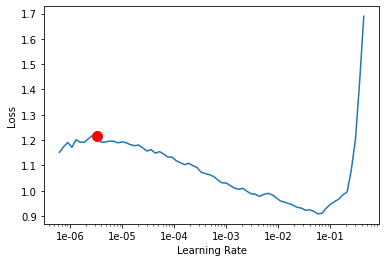

In [22]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [23]:
learn.fit_one_cycle(12, slice(3e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.151621,1.987834,0.445455,0.734025,00:08
1,0.972996,1.394753,0.390909,0.749080,00:06
2,0.913126,1.178747,0.309091,0.767815,00:06
3,0.855906,1.025615,0.245455,0.813315,00:06
4,0.795190,0.881671,0.254545,0.831716,00:06
5,0.768104,0.836444,0.236364,0.850452,00:06
6,0.726851,0.634527,0.200000,0.873871,00:06
7,0.701283,0.474865,0.190909,0.900970,00:06
8,0.666747,0.466416,0.181818,0.912345,00:06
9,0.634744,0.466260,0.163636,0.904650,00:06


In [24]:
learn.save('binary-1')

In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


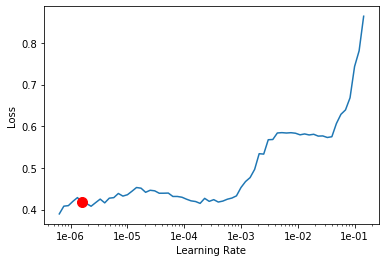

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(8, slice(6e-8, 1e-6))

epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.494067,0.415647,0.145455,0.922717,00:06
1,0.490391,0.408329,0.145455,0.923720,00:06
2,0.516067,0.397315,0.145455,0.928739,00:06
3,0.498958,0.385020,0.136364,0.932419,00:06
4,0.481583,0.379971,0.100000,0.934426,00:07
5,0.476648,0.378307,0.118182,0.934426,00:06
6,0.463224,0.380323,0.109091,0.932419,00:06
7,0.453837,0.374341,0.109091,0.935095,00:06


In [28]:
learn.save('binary-2')

In [29]:
learn.fit_one_cycle(10, slice(6e-8//400, 1e-6//100))

epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.481468,0.369619,0.100000,0.933423,00:07
1,0.491807,0.369022,0.100000,0.935095,00:06
2,0.472969,0.373849,0.118182,0.934092,00:06
3,0.457318,0.378871,0.118182,0.934426,00:06
4,0.477173,0.371200,0.127273,0.935764,00:06
5,0.483287,0.372836,0.118182,0.936434,00:06
6,0.520032,0.373404,0.118182,0.934761,00:06
7,0.509488,0.369549,0.109091,0.936434,00:06
8,0.498828,0.369176,0.100000,0.935095,00:06
9,0.483723,0.374384,0.145455,0.933757,00:06


In [36]:
learn.load('binary-2');

In [37]:
learn.fit_one_cycle(1, slice(6e-8//400, 1e-6//100))

epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.385849,0.373629,0.118182,0.933757,00:06


In [38]:
learn.save('binary-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.58E-05


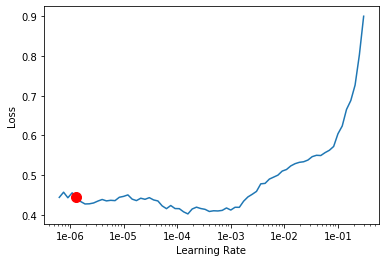

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(25, slice(2e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.434884,0.372219,0.136364,0.933088,00:07
1,0.426823,0.370954,0.136364,0.933757,00:06
2,0.455365,0.371362,0.118182,0.937772,00:07
3,0.440327,0.376773,0.127273,0.936768,00:07
4,0.447969,0.359033,0.118182,0.942121,00:06
5,0.450276,0.345749,0.118182,0.943125,00:06
6,0.433658,0.374714,0.109091,0.934761,00:06
7,0.414622,0.394308,0.118182,0.929742,00:07
8,0.410804,0.415575,0.127273,0.927066,00:06
9,0.411709,0.475896,0.118182,0.924724,00:06


In [41]:
learn.save('binary-4')

In [43]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [44]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model_dir="./KL_Models"

In [45]:
learn.load('binary-4')

Learner(data=ImageDataBunch;

Train: LabelList (436 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
No_Surgery,Surgery,Surgery,Surgery,No_Surgery
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Valid: LabelList (110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surgery,Surgery,Surgery,No_Surgery,No_Surgery
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64

In [46]:
preds, y = learn.get_preds()

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

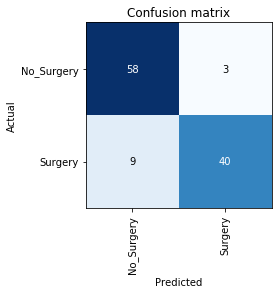

In [48]:
interp.plot_confusion_matrix()

In [50]:
interp.top_losses()

torch.return_types.topk(
values=tensor([1.0573e+01, 5.7796e+00, 3.6120e+00, 3.3182e+00, 3.0119e+00, 2.8839e+00,
        2.3094e+00, 1.4914e+00, 9.1024e-01, 8.9258e-01, 8.5412e-01, 7.5946e-01,
        6.2136e-01, 6.0771e-01, 5.9328e-01, 5.7619e-01, 4.9328e-01, 4.5719e-01,
        4.5593e-01, 4.2360e-01, 4.0266e-01, 3.5193e-01, 3.5033e-01, 2.2619e-01,
        2.1640e-01, 1.8022e-01, 1.7289e-01, 1.4815e-01, 1.4592e-01, 1.3560e-01,
        1.2318e-01, 1.1469e-01, 1.0223e-01, 8.9624e-02, 5.1590e-02, 4.0702e-02,
        3.6593e-02, 3.3365e-02, 3.3121e-02, 3.2411e-02, 2.8033e-02, 2.2601e-02,
        2.1963e-02, 2.0805e-02, 2.0329e-02, 1.7388e-02, 1.6661e-02, 1.5261e-02,
        1.1590e-02, 1.1211e-02, 8.2908e-03, 8.1769e-03, 7.8914e-03, 7.7506e-03,
        7.5613e-03, 7.3978e-03, 6.3872e-03, 6.2203e-03, 6.1311e-03, 5.5362e-03,
        5.5295e-03, 5.1798e-03, 3.5071e-03, 3.4202e-03, 2.7674e-03, 2.4948e-03,
        2.3848e-03, 1.3519e-03, 1.3484e-03, 1.2216e-03, 1.1491e-03, 1.0547e-03,
        

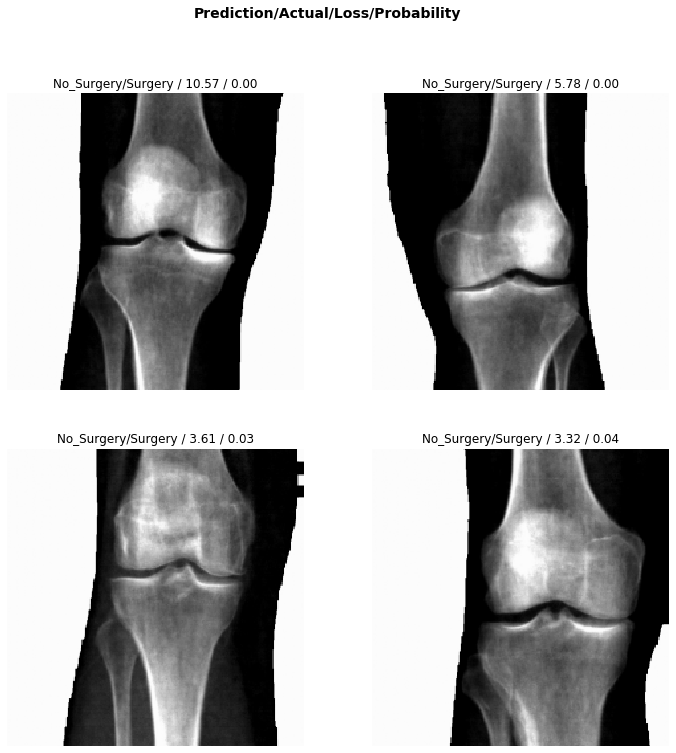

In [53]:
interp.plot_top_losses(4)

In [55]:
fp = [y for x in false_pos for y in x]; tp = [y for x in true_pos for y in x]

In [65]:
rocauc = RocAUC[-1]

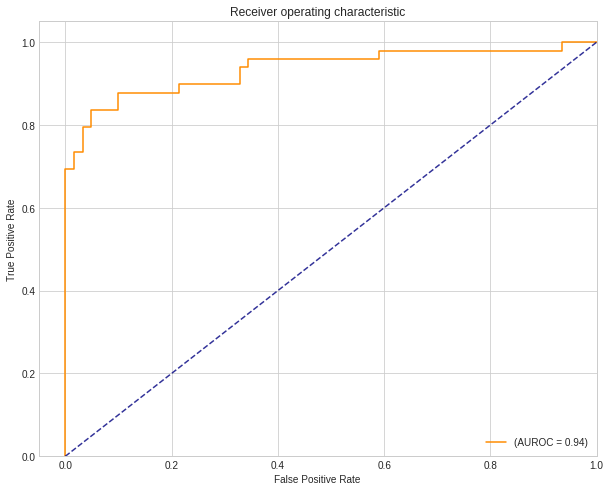

In [68]:
plt.figure(figsize = (10,8))
plt.style.use('seaborn-whitegrid')
lw = 1.5

plt.plot(fp, tp, color='darkorange',
         lw=lw, alpha = 1, label='(AUROC = %0.2f)' % rocauc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha = 0.8)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Interpretation

The model performed much better at the binary task of triaging patients for surgery, based on their KL grade. This mimics what was observed in the clinical grade analysis, where clinicians were better able to distinguish grades within a class (high grade), but were less able to consistently grade given all five options. Thus, option is to try and ensemble method where you first separate images based on whether they would benefit from surery, then, within the two classes train sepearate networks to classify the different grades of severity. This could be followed up with a similar test in the clinician graders themselves, to see if their performance increases when classes are subset in this way. 

# Clinician Grades

In [25]:
grades = pd.read_csv("consensus_grades.csv")

In [26]:
grades

,d1_idx,deck1_kk,deck1_pj,deck1_consensus,d2_idx,deck2_kk,deck2_ka,deck2_consensus,d3_idx,deck3_pj,...,hg1_pj,hg1_consensus,hg2_idx,hg2_kk,hg2_ka,hg2_consensus,hg3_idx,hg3_pj,hg3_ka,hg3_consensus
0,1,2,3,3,1,2,1,2,1,1,...,2.0,3.0,1,3.0,4.0,4.0,1,2.0,2.0,2.0
1,2,1,2,2,2,2,1,2,2,3,...,3.0,3.0,2,3.0,3.0,3.0,2,2.0,1.0,2.0
2,3,0,0,0,3,3,2,2,3,4,...,3.0,3.0,3,3.0,3.0,3.0,3,4.0,3.0,3.0
3,4,0,0,0,4,2,1,1,4,3,...,4.0,4.0,4,4.0,3.0,4.0,4,2.0,1.0,2.0
4,5,2,2,2,5,1,0,1,5,2,...,4.0,4.0,5,3.0,4.0,4.0,5,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1,0,1,96,3,1,2,96,3,...,NaN,NaN,96,NaN,NaN,NaN,96,NaN,NaN,NaN
96,97,1,2,1,97,3,1,2,97,3,...,NaN,NaN,97,NaN,NaN,NaN,97,NaN,NaN,NaN
97,98,2,1,2,98,2,1,2,98,1,...,NaN,NaN,98,NaN,NaN,NaN,98,NaN,NaN,NaN
98,99,2,2,2,99,2,0,1,99,2,...,NaN,NaN,99,NaN,NaN,NaN,99,NaN,NaN,NaN


In [53]:
d1_kk = grades['deck1_kk']

In [41]:
d1 = d1_kk.to_numpy()

In [54]:
truth = grades['deck1_consensus']
y = truth.to_numpy()

In [43]:
y

array([3, 2, 0, 0, ..., 1, 2, 2, 2])

In [21]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[ 4  0  0  0  0]
 [ 0 31  0  0  0]
 [ 0  4 45  1  0]
 [ 0  0  3 11  0]
 [ 0  0  0  0  1]]


In [23]:
d1_pj = grades['deck1_pj']

In [57]:
g = d1_kk.to_numpy()

In [58]:
t = truth.to_numpy()

In [60]:
matrix = confusion_matrix(g, t)
print(matrix)

[[ 4  0  0  0  0]
 [ 0 31  4  0  0]
 [ 0  0 45  3  0]
 [ 0  0  1 11  0]
 [ 0  0  0  0  1]]


In [49]:
d1_kk.to_numpy()

array([2, 1, 0, 0, ..., 1, 2, 2, 2])

In [47]:
d1.argmax(axis=1)

array([2, 1, 0, 0, ..., 1, 2, 2, 2])

In [50]:
truth

0     3
1     2
2     0
3     0
4     2
     ..
95    1
96    1
97    2
98    2
99    2
Name: deck1_consensus, Length: 100, dtype: int64

In [61]:
pj = d1_pj.to_numpy()

In [62]:
matrix = confusion_matrix(pj, g)
print(matrix)

[[ 4  5  0  0  0]
 [ 0 24  2  1  0]
 [ 0  6 38  0  0]
 [ 0  0  8  9  0]
 [ 0  0  0  2  1]]


In [63]:
from sklearn.metrics import confusion_matrix as cmatrix
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
def plot_cm(cm, title="Your Confusion Matrix Plot", cmap="YlGnBu", figheight=10, figwidth=8):
    plt.figure(figsize=(figheight, figwidth))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap="YlGnBu", fmt='g');
    
    ax.set_xlabel('Predicted');ax.set_ylabel('Actual');
    ax.set_title(title);
    ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4']); ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4']);

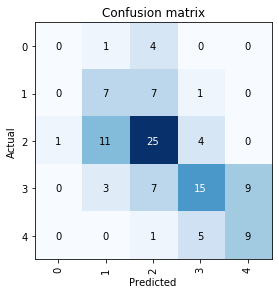

In [47]:
interp.plot_confusion_matrix()

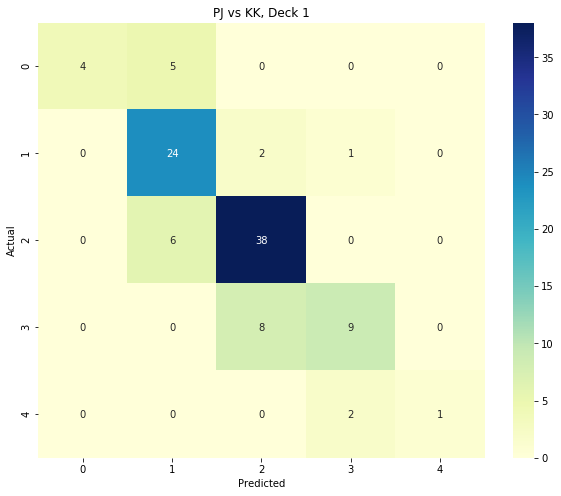

In [67]:
plot_cm(matrix, "PJ vs KK, Deck 1")

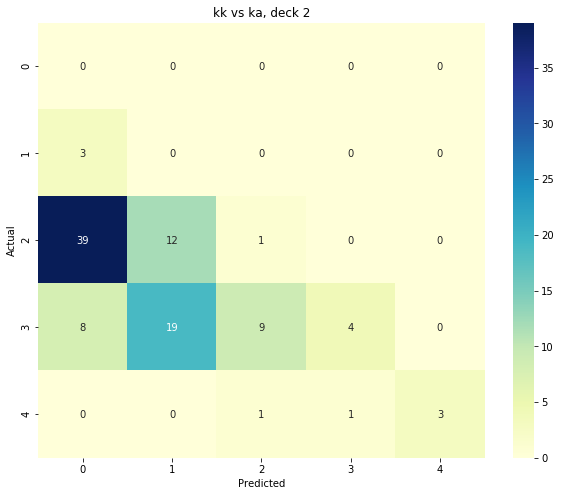

In [78]:
plot_cm(matrix, "kk vs ka, deck 2")

In [53]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(pj, g)

0.76

In [70]:
accuracy_score(t, pj)

0.83

In [71]:
accuracy_score(t, g)

0.92

In [72]:
grades

,d1_idx,deck1_kk,deck1_pj,deck1_consensus,d2_idx,deck2_kk,deck2_ka,deck2_consensus,d3_idx,deck3_pj,...,hg1_pj,hg1_consensus,hg2_idx,hg2_kk,hg2_ka,hg2_consensus,hg3_idx,hg3_pj,hg3_ka,hg3_consensus
0,1,2,3,3,1,2,1,2,1,1,...,2.0,3.0,1,3.0,4.0,4.0,1,2.0,2.0,2.0
1,2,1,2,2,2,2,1,2,2,3,...,3.0,3.0,2,3.0,3.0,3.0,2,2.0,1.0,2.0
2,3,0,0,0,3,3,2,2,3,4,...,3.0,3.0,3,3.0,3.0,3.0,3,4.0,3.0,3.0
3,4,0,0,0,4,2,1,1,4,3,...,4.0,4.0,4,4.0,3.0,4.0,4,2.0,1.0,2.0
4,5,2,2,2,5,1,0,1,5,2,...,4.0,4.0,5,3.0,4.0,4.0,5,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1,0,1,96,3,1,2,96,3,...,NaN,NaN,96,NaN,NaN,NaN,96,NaN,NaN,NaN
96,97,1,2,1,97,3,1,2,97,3,...,NaN,NaN,97,NaN,NaN,NaN,97,NaN,NaN,NaN
97,98,2,1,2,98,2,1,2,98,1,...,NaN,NaN,98,NaN,NaN,NaN,98,NaN,NaN,NaN
98,99,2,2,2,99,2,0,1,99,2,...,NaN,NaN,99,NaN,NaN,NaN,99,NaN,NaN,NaN


In [73]:
d2_kk = grades['deck2_kk'].to_numpy()

In [75]:
d2_truth = grades['deck2_consensus'].to_numpy()

In [76]:
d2_ka = grades['deck2_ka'].to_numpy()

In [77]:
matrix = confusion_matrix(d2_kk, d2_ka)

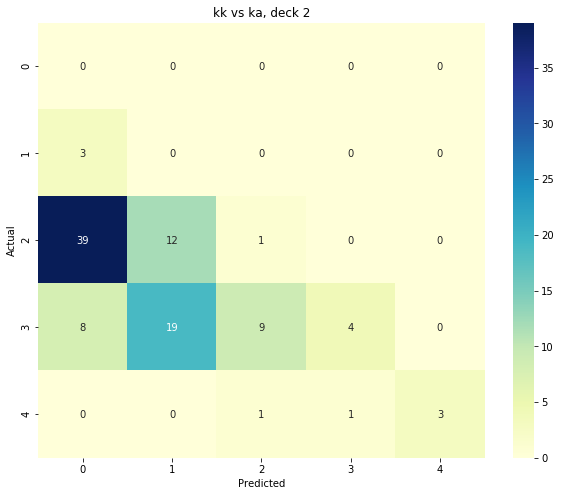

In [78]:
plot_cm(matrix, "kk vs ka, deck 2")

In [79]:
accuracy_score(d2_ka, d2_kk)

0.08

In [80]:
accuracy_score(d2_truth, d2_ka)

0.14

In [82]:
accuracy_score(d2_truth, d2_kk)

0.58

In [83]:
d3_ka = grades['deck3_ka'].to_numpy()

In [84]:
d3_pj = grades['deck3_pj'].to_numpy()

In [85]:
d3_truth = grades['deck3_consensus'].to_numpy()

In [86]:
accuracy_score(d3_ka, d3_pj)

0.24

In [87]:
accuracy_score(d3_truth, d3_pj)

0.73

In [88]:
accuracy_score(d3_truth, d3_ka)

0.36

In [ ]:
# Intra clin average: 0.36
# Intra clin consensus average: 0.59333


In [100]:
clin_consensus = np.array([0.83, 0.92, 0.14, 0.58, 0.73, 0.36])
np.mean(clin_consensus)

0.5933333333333334

In [91]:
np.std(clin_consensus)

0.2712727205026132

In [102]:
clin = np.array([0.08, 0.24, 0.76])
np.mean(clin)

0.36000000000000004

In [93]:
np.std(clin)

0.2902872140943632

In [101]:
np.mean(np.array([0.64, 0.585, 0.205]))

0.47666666666666674

In [99]:
np.std(np.array([0.64, 0.585, 0.205]))

0.19340515907171543

In [16]:
# from model
p = np.argmax(preds, axis=1)

In [18]:
y

tensor([4, 3, 4, 2, 2, 3, 2, 2, 3, 3, 1, 4, 3, 3, 3, 3, 4, 1, 3, 2, 2, 2, 1, 3,
        1, 0, 4, 2, 1, 4, 2, 4, 1, 4, 3, 3, 0, 3, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2,
        3, 2, 2, 3, 1, 3, 4, 3, 1, 3, 2, 3, 3, 4, 0, 3, 2, 2, 3, 2, 2, 2, 3, 2,
        4, 2, 3, 1, 1, 3, 2, 4, 2, 3, 2, 4, 2, 2, 3, 3, 3, 1, 0, 1, 4, 2, 2, 2,
        2, 1, 2, 2, 3, 0, 2, 2, 3, 3, 1, 3, 2, 1])

In [20]:
p

tensor([4, 4, 4, 2, 2, 1, 2, 2, 4, 3, 1, 4, 3, 3, 4, 3, 4, 2, 2, 2, 3, 2, 2, 2,
        2, 2, 2, 2, 1, 3, 2, 4, 2, 3, 4, 3, 2, 3, 4, 2, 3, 3, 2, 1, 2, 2, 2, 2,
        3, 3, 1, 3, 3, 3, 3, 2, 2, 4, 3, 4, 4, 4, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2,
        3, 2, 3, 1, 1, 1, 1, 4, 1, 2, 2, 4, 2, 1, 3, 4, 3, 1, 2, 1, 3, 1, 2, 2,
        2, 2, 1, 2, 4, 1, 1, 1, 3, 3, 1, 2, 2, 2])

In [23]:
f1_score(y, p, average='micro')

0.509090909090909

In [24]:
f1_score(y, p, average = 'macro')

0.4041085588443515

In [27]:
grades

,d1_idx,deck1_kk,deck1_pj,deck1_consensus,d2_idx,deck2_kk,deck2_ka,deck2_consensus,d3_idx,deck3_pj,...,hg1_pj,hg1_consensus,hg2_idx,hg2_kk,hg2_ka,hg2_consensus,hg3_idx,hg3_pj,hg3_ka,hg3_consensus
0,1,2,3,3,1,2,1,2,1,1,...,2.0,3.0,1,3.0,4.0,4.0,1,2.0,2.0,2.0
1,2,1,2,2,2,2,1,2,2,3,...,3.0,3.0,2,3.0,3.0,3.0,2,2.0,1.0,2.0
2,3,0,0,0,3,3,2,2,3,4,...,3.0,3.0,3,3.0,3.0,3.0,3,4.0,3.0,3.0
3,4,0,0,0,4,2,1,1,4,3,...,4.0,4.0,4,4.0,3.0,4.0,4,2.0,1.0,2.0
4,5,2,2,2,5,1,0,1,5,2,...,4.0,4.0,5,3.0,4.0,4.0,5,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1,0,1,96,3,1,2,96,3,...,NaN,NaN,96,NaN,NaN,NaN,96,NaN,NaN,NaN
96,97,1,2,1,97,3,1,2,97,3,...,NaN,NaN,97,NaN,NaN,NaN,97,NaN,NaN,NaN
97,98,2,1,2,98,2,1,2,98,1,...,NaN,NaN,98,NaN,NaN,NaN,98,NaN,NaN,NaN
98,99,2,2,2,99,2,0,1,99,2,...,NaN,NaN,99,NaN,NaN,NaN,99,NaN,NaN,NaN


In [28]:
pred = grades['deck2_kk'].to_numpy()

In [29]:
tru = grades['deck2_consensus'].to_numpy()

In [30]:
f1_score(tru, pred, average = 'micro')

0.58

In [31]:
f1_score(tru, pred, average = 'macro')

0.4356237301909792

In [33]:
pred = grades['deck2_ka'].to_numpy()

In [34]:
f1_score(tru, pred, average = 'micro')

0.14

In [35]:
f1_score(tru, pred, average = 'macro')

0.3231921020156314

In [38]:
grades.columns

Index(['d1_idx', 'deck1_kk', 'deck1_pj', 'deck1_consensus', 'd2_idx',
       'deck2_kk', 'deck2_ka', 'deck2_consensus', 'd3_idx', 'deck3_pj',
       'deck3_ka', 'deck3_consensus', 'hg1_idx', 'hg1_kk', 'hg1_pj',
       'hg1_consensus', 'hg2_idx', 'hg2_kk', 'hg2_ka', 'hg2_consensus',
       'hg3_idx', 'hg3_pj', 'hg3_ka', 'hg3_consensus'],
      dtype='object')

In [39]:
pred = grades['deck1_kk'].to_numpy()
tru = grades['deck1_consensus'].to_numpy()

In [40]:
f1_score(tru, pred, average = 'micro')

0.92

In [41]:
f1_score(tru, pred, average = 'macro')

0.9407830264973122

In [42]:
pred = grades['deck3_ka'].to_numpy()
tru = grades['deck3_consensus'].to_numpy()

In [43]:
f1_score(tru, pred, average = 'micro')

0.36

In [44]:
f1_score(tru, pred, average = 'macro')

0.5074987997726466

In [45]:
pred = grades['deck1_pj'].to_numpy()
tru = grades['deck1_consensus'].to_numpy()

In [46]:
f1_score(tru, pred, average = 'micro')

0.83

In [47]:
f1_score(tru, pred, average = 'macro')

0.722156278388972

In [48]:
pred = grades['deck3_pj'].to_numpy()
tru = grades['deck3_consensus'].to_numpy()

In [49]:
f1_score(tru, pred, average = 'micro')

0.7299999999999999

In [50]:
f1_score(tru, pred, average = 'macro')

0.6599115826702034

In [54]:
grades.columns

Index(['d1_idx', 'deck1_kk', 'deck1_pj', 'deck1_consensus', 'd2_idx',
       'deck2_kk', 'deck2_ka', 'deck2_consensus', 'd3_idx', 'deck3_pj',
       'deck3_ka', 'deck3_consensus', 'hg1_idx', 'hg1_kk', 'hg1_pj',
       'hg1_consensus', 'hg2_idx', 'hg2_kk', 'hg2_ka', 'hg2_consensus',
       'hg3_idx', 'hg3_pj', 'hg3_ka', 'hg3_consensus'],
      dtype='object')

In [63]:
pred = grades['hg1_pj'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg1_consensus'].to_numpy()
y = tru[~pd.isnull(tru)]

In [65]:
pred = x.astype(int)
tru = y.astype(int)
tru

array([3, 3, 3, 4, ..., 3, 3, 4, 4])

In [66]:
accuracy_score(tru, pred)

0.9146341463414634

In [67]:
pred = grades['hg1_kk'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg1_consensus'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [68]:
accuracy_score(tru, pred)

0.8048780487804879

In [69]:
pred = grades['hg1_kk'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg1_pj'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [70]:
accuracy_score(tru, pred)

0.7195121951219512

In [75]:
pred = grades['hg2_kk'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg2_consensus'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [76]:
accuracy_score(tru, pred)

0.8048780487804879

In [77]:
pred = grades['hg2_ka'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg2_consensus'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [78]:
accuracy_score(tru, pred)

0.4878048780487805

In [79]:
pred = grades['hg2_ka'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg2_kk'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [80]:
accuracy_score(tru, pred)

0.3170731707317073

In [81]:
pred = grades['hg3_ka'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg3_consensus'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [82]:
accuracy_score(tru, pred)

0.7073170731707317

In [83]:
pred = grades['hg3_pj'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg3_consensus'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [84]:
accuracy_score(tru, pred)

0.8048780487804879

In [85]:
pred = grades['hg3_pj'].to_numpy()
x = pred[~pd.isnull(pred)]
tru = grades['hg3_ka'].to_numpy()
y = tru[~pd.isnull(tru)]
pred = x.astype(int)
tru = y.astype(int)

In [86]:
accuracy_score(tru, pred)

0.5365853658536586

In [87]:
54+32+72

158

In [88]:
158/3

52.666666666666664

In [89]:
# ka
.70  + .48

1.18

In [90]:
1.18/2

0.59

In [91]:
# kk
.80

0.8

In [93]:
91+80

171

In [94]:
171/2

85.5

In [ ]:
# pj 
.86